# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

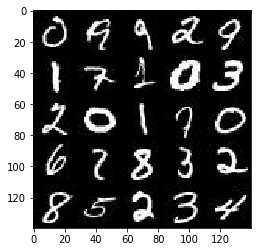

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

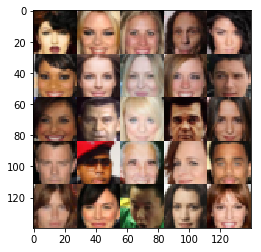

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learn_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return real_input, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [30]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28 x 28 x channels
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', \
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1, x1)
        # 14 x 14 x 64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same', \
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7 x 7 x 128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same', \
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4 x 4 x 256
        
        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits) 

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [31]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    inf = not is_train
    with tf.variable_scope('generator', reuse=inf):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7 x 7 x 512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7 x 7 x 256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14 x 14 x 128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x 28 x out_channel_dim now
        
        out = tf.tanh(logits)    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [32]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [33]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [35]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model

    input_real, input_z, learn_rate = model_inputs(*data_shape[1:4], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Normalize the images to be between -1.0 and 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,\
                                                   learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, \
                                                  learn_rate: learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    #losses.append((train_loss_d, train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 0.9447... Generator Loss: 5.6040
Epoch 1/2... Batch 20... Discriminator Loss: 4.0008... Generator Loss: 9.3830
Epoch 1/2... Batch 30... Discriminator Loss: 1.2280... Generator Loss: 1.4475
Epoch 1/2... Batch 40... Discriminator Loss: 0.9832... Generator Loss: 1.0942
Epoch 1/2... Batch 50... Discriminator Loss: 2.0318... Generator Loss: 0.3241
Epoch 1/2... Batch 60... Discriminator Loss: 1.0460... Generator Loss: 1.1457
Epoch 1/2... Batch 70... Discriminator Loss: 1.3682... Generator Loss: 2.0423
Epoch 1/2... Batch 80... Discriminator Loss: 1.3165... Generator Loss: 0.7488
Epoch 1/2... Batch 90... Discriminator Loss: 1.0863... Generator Loss: 0.8745
Epoch 1/2... Batch 100... Discriminator Loss: 1.2699... Generator Loss: 0.7569


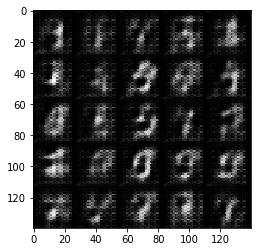

Epoch 1/2... Batch 110... Discriminator Loss: 1.8726... Generator Loss: 2.1388
Epoch 1/2... Batch 120... Discriminator Loss: 1.1807... Generator Loss: 0.9283
Epoch 1/2... Batch 130... Discriminator Loss: 1.1067... Generator Loss: 0.9536
Epoch 1/2... Batch 140... Discriminator Loss: 1.1947... Generator Loss: 1.5857
Epoch 1/2... Batch 150... Discriminator Loss: 1.4924... Generator Loss: 0.7442
Epoch 1/2... Batch 160... Discriminator Loss: 1.4017... Generator Loss: 0.5383
Epoch 1/2... Batch 170... Discriminator Loss: 1.4223... Generator Loss: 0.5620
Epoch 1/2... Batch 180... Discriminator Loss: 1.4549... Generator Loss: 1.3470
Epoch 1/2... Batch 190... Discriminator Loss: 1.7347... Generator Loss: 1.9567
Epoch 1/2... Batch 200... Discriminator Loss: 1.1074... Generator Loss: 1.1773


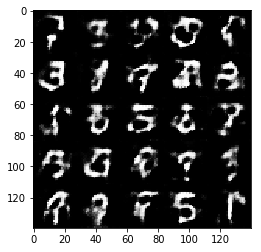

Epoch 1/2... Batch 210... Discriminator Loss: 1.8847... Generator Loss: 1.6499
Epoch 1/2... Batch 220... Discriminator Loss: 1.4900... Generator Loss: 1.0730
Epoch 1/2... Batch 230... Discriminator Loss: 1.0387... Generator Loss: 1.0909
Epoch 1/2... Batch 240... Discriminator Loss: 1.3326... Generator Loss: 1.3288
Epoch 1/2... Batch 250... Discriminator Loss: 1.3891... Generator Loss: 1.1628
Epoch 1/2... Batch 260... Discriminator Loss: 1.2426... Generator Loss: 0.8853
Epoch 1/2... Batch 270... Discriminator Loss: 1.3775... Generator Loss: 1.7570
Epoch 1/2... Batch 280... Discriminator Loss: 1.1274... Generator Loss: 0.8337
Epoch 1/2... Batch 290... Discriminator Loss: 1.0653... Generator Loss: 1.1534
Epoch 1/2... Batch 300... Discriminator Loss: 1.2701... Generator Loss: 0.8237


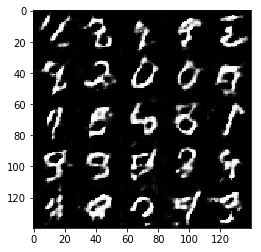

Epoch 1/2... Batch 310... Discriminator Loss: 1.3732... Generator Loss: 1.1366
Epoch 1/2... Batch 320... Discriminator Loss: 1.2012... Generator Loss: 1.4805
Epoch 1/2... Batch 330... Discriminator Loss: 1.2596... Generator Loss: 0.8203
Epoch 1/2... Batch 340... Discriminator Loss: 1.3602... Generator Loss: 0.6015
Epoch 1/2... Batch 350... Discriminator Loss: 1.2139... Generator Loss: 0.7579
Epoch 1/2... Batch 360... Discriminator Loss: 1.1467... Generator Loss: 1.2926
Epoch 1/2... Batch 370... Discriminator Loss: 1.2863... Generator Loss: 0.6717
Epoch 1/2... Batch 380... Discriminator Loss: 1.2150... Generator Loss: 0.9488
Epoch 1/2... Batch 390... Discriminator Loss: 1.3056... Generator Loss: 1.4435
Epoch 1/2... Batch 400... Discriminator Loss: 1.8538... Generator Loss: 0.3426


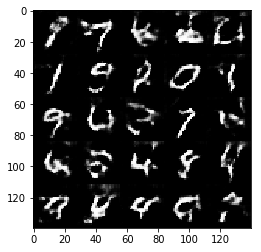

Epoch 1/2... Batch 410... Discriminator Loss: 1.2270... Generator Loss: 0.7696
Epoch 1/2... Batch 420... Discriminator Loss: 1.3565... Generator Loss: 1.7715
Epoch 1/2... Batch 430... Discriminator Loss: 1.3734... Generator Loss: 1.6588
Epoch 1/2... Batch 440... Discriminator Loss: 1.3680... Generator Loss: 0.5788
Epoch 1/2... Batch 450... Discriminator Loss: 1.1998... Generator Loss: 0.8235
Epoch 1/2... Batch 460... Discriminator Loss: 1.3239... Generator Loss: 0.6752
Epoch 1/2... Batch 470... Discriminator Loss: 1.1017... Generator Loss: 0.8636
Epoch 1/2... Batch 480... Discriminator Loss: 1.2292... Generator Loss: 0.7905
Epoch 1/2... Batch 490... Discriminator Loss: 1.2839... Generator Loss: 0.7234
Epoch 1/2... Batch 500... Discriminator Loss: 1.4813... Generator Loss: 0.4908


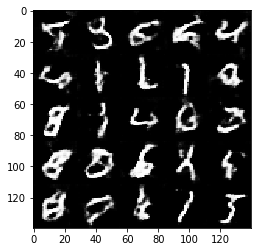

Epoch 1/2... Batch 510... Discriminator Loss: 1.1420... Generator Loss: 0.9733
Epoch 1/2... Batch 520... Discriminator Loss: 1.1772... Generator Loss: 0.7403
Epoch 1/2... Batch 530... Discriminator Loss: 1.2667... Generator Loss: 0.6290
Epoch 1/2... Batch 540... Discriminator Loss: 1.2598... Generator Loss: 1.0853
Epoch 1/2... Batch 550... Discriminator Loss: 1.2205... Generator Loss: 0.8573
Epoch 1/2... Batch 560... Discriminator Loss: 1.4547... Generator Loss: 0.5177
Epoch 1/2... Batch 570... Discriminator Loss: 1.0859... Generator Loss: 0.9553
Epoch 1/2... Batch 580... Discriminator Loss: 1.2428... Generator Loss: 0.6911
Epoch 1/2... Batch 590... Discriminator Loss: 1.2329... Generator Loss: 1.1746
Epoch 1/2... Batch 600... Discriminator Loss: 1.1153... Generator Loss: 1.0980


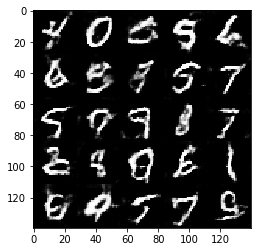

Epoch 1/2... Batch 610... Discriminator Loss: 1.2957... Generator Loss: 0.7173
Epoch 1/2... Batch 620... Discriminator Loss: 1.4938... Generator Loss: 0.5161
Epoch 1/2... Batch 630... Discriminator Loss: 1.1966... Generator Loss: 0.9129
Epoch 1/2... Batch 640... Discriminator Loss: 1.2116... Generator Loss: 1.0962
Epoch 1/2... Batch 650... Discriminator Loss: 1.6492... Generator Loss: 0.3962
Epoch 1/2... Batch 660... Discriminator Loss: 1.0901... Generator Loss: 1.0503
Epoch 1/2... Batch 670... Discriminator Loss: 1.1309... Generator Loss: 1.4744
Epoch 1/2... Batch 680... Discriminator Loss: 1.6912... Generator Loss: 0.3845
Epoch 1/2... Batch 690... Discriminator Loss: 1.5409... Generator Loss: 0.4586
Epoch 1/2... Batch 700... Discriminator Loss: 1.0709... Generator Loss: 1.1404


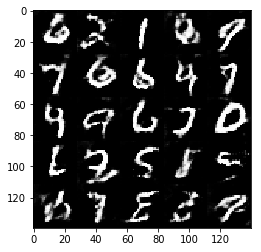

Epoch 1/2... Batch 710... Discriminator Loss: 1.1212... Generator Loss: 0.8631
Epoch 1/2... Batch 720... Discriminator Loss: 1.2046... Generator Loss: 1.5293
Epoch 1/2... Batch 730... Discriminator Loss: 1.3932... Generator Loss: 1.8902
Epoch 1/2... Batch 740... Discriminator Loss: 1.1966... Generator Loss: 1.1186
Epoch 1/2... Batch 750... Discriminator Loss: 1.1567... Generator Loss: 1.1488
Epoch 1/2... Batch 760... Discriminator Loss: 1.3005... Generator Loss: 0.6058
Epoch 1/2... Batch 770... Discriminator Loss: 1.0198... Generator Loss: 1.4900
Epoch 1/2... Batch 780... Discriminator Loss: 2.0185... Generator Loss: 0.2565
Epoch 1/2... Batch 790... Discriminator Loss: 1.3276... Generator Loss: 2.2143
Epoch 1/2... Batch 800... Discriminator Loss: 1.0717... Generator Loss: 1.0000


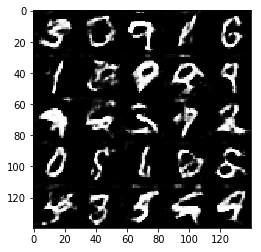

Epoch 1/2... Batch 810... Discriminator Loss: 1.2601... Generator Loss: 0.6829
Epoch 1/2... Batch 820... Discriminator Loss: 1.1845... Generator Loss: 0.7822
Epoch 1/2... Batch 830... Discriminator Loss: 1.1466... Generator Loss: 1.3220
Epoch 1/2... Batch 840... Discriminator Loss: 1.1836... Generator Loss: 1.8946
Epoch 1/2... Batch 850... Discriminator Loss: 1.6707... Generator Loss: 0.4371
Epoch 1/2... Batch 860... Discriminator Loss: 1.5515... Generator Loss: 0.4610
Epoch 1/2... Batch 870... Discriminator Loss: 1.1244... Generator Loss: 0.9404
Epoch 1/2... Batch 880... Discriminator Loss: 1.0818... Generator Loss: 0.9161
Epoch 1/2... Batch 890... Discriminator Loss: 1.0843... Generator Loss: 0.9210
Epoch 1/2... Batch 900... Discriminator Loss: 1.0334... Generator Loss: 1.1093


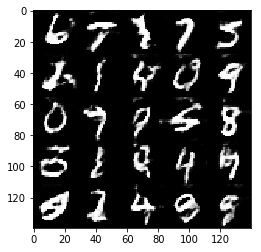

Epoch 1/2... Batch 910... Discriminator Loss: 1.3299... Generator Loss: 0.6757
Epoch 1/2... Batch 920... Discriminator Loss: 1.9643... Generator Loss: 3.2114
Epoch 1/2... Batch 930... Discriminator Loss: 1.0032... Generator Loss: 1.0392
Epoch 2/2... Batch 10... Discriminator Loss: 1.2502... Generator Loss: 0.7553
Epoch 2/2... Batch 20... Discriminator Loss: 1.2498... Generator Loss: 1.3134
Epoch 2/2... Batch 30... Discriminator Loss: 1.2300... Generator Loss: 0.6575
Epoch 2/2... Batch 40... Discriminator Loss: 2.3678... Generator Loss: 0.2070
Epoch 2/2... Batch 50... Discriminator Loss: 1.2896... Generator Loss: 1.2774
Epoch 2/2... Batch 60... Discriminator Loss: 1.5427... Generator Loss: 0.4499
Epoch 2/2... Batch 70... Discriminator Loss: 1.3023... Generator Loss: 0.6356
Epoch 2/2... Batch 80... Discriminator Loss: 1.4525... Generator Loss: 0.5161
Epoch 2/2... Batch 90... Discriminator Loss: 1.0741... Generator Loss: 1.2778
Epoch 2/2... Batch 100... Discriminator Loss: 0.9758... Gener

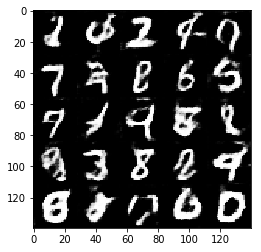

Epoch 2/2... Batch 110... Discriminator Loss: 1.1699... Generator Loss: 1.4705
Epoch 2/2... Batch 120... Discriminator Loss: 1.8280... Generator Loss: 0.3348
Epoch 2/2... Batch 130... Discriminator Loss: 1.1120... Generator Loss: 0.8803
Epoch 2/2... Batch 140... Discriminator Loss: 1.1615... Generator Loss: 1.0257
Epoch 2/2... Batch 150... Discriminator Loss: 1.4216... Generator Loss: 0.5624
Epoch 2/2... Batch 160... Discriminator Loss: 1.1642... Generator Loss: 0.8663
Epoch 2/2... Batch 170... Discriminator Loss: 1.0661... Generator Loss: 0.9874
Epoch 2/2... Batch 180... Discriminator Loss: 1.2233... Generator Loss: 0.6937
Epoch 2/2... Batch 190... Discriminator Loss: 1.2860... Generator Loss: 0.7390
Epoch 2/2... Batch 200... Discriminator Loss: 1.1654... Generator Loss: 0.8709


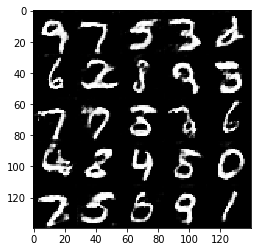

Epoch 2/2... Batch 210... Discriminator Loss: 1.3799... Generator Loss: 0.5057
Epoch 2/2... Batch 220... Discriminator Loss: 1.6203... Generator Loss: 0.3917
Epoch 2/2... Batch 230... Discriminator Loss: 0.9818... Generator Loss: 0.9921
Epoch 2/2... Batch 240... Discriminator Loss: 0.9845... Generator Loss: 0.9499
Epoch 2/2... Batch 250... Discriminator Loss: 1.1043... Generator Loss: 0.8816
Epoch 2/2... Batch 260... Discriminator Loss: 2.0812... Generator Loss: 2.9805
Epoch 2/2... Batch 270... Discriminator Loss: 1.1319... Generator Loss: 0.7959
Epoch 2/2... Batch 280... Discriminator Loss: 1.5103... Generator Loss: 0.4903
Epoch 2/2... Batch 290... Discriminator Loss: 0.8951... Generator Loss: 1.3791
Epoch 2/2... Batch 300... Discriminator Loss: 1.5147... Generator Loss: 0.5200


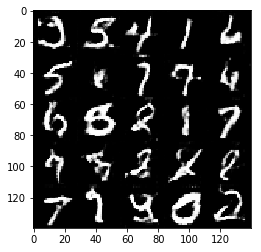

Epoch 2/2... Batch 310... Discriminator Loss: 1.3119... Generator Loss: 0.7187
Epoch 2/2... Batch 320... Discriminator Loss: 1.4859... Generator Loss: 0.5247
Epoch 2/2... Batch 330... Discriminator Loss: 0.9096... Generator Loss: 1.5080
Epoch 2/2... Batch 340... Discriminator Loss: 1.1121... Generator Loss: 0.8610
Epoch 2/2... Batch 350... Discriminator Loss: 1.1185... Generator Loss: 0.7770
Epoch 2/2... Batch 360... Discriminator Loss: 1.3754... Generator Loss: 2.4866
Epoch 2/2... Batch 370... Discriminator Loss: 1.1491... Generator Loss: 0.7453
Epoch 2/2... Batch 380... Discriminator Loss: 2.0109... Generator Loss: 3.3547
Epoch 2/2... Batch 390... Discriminator Loss: 1.1279... Generator Loss: 0.9680
Epoch 2/2... Batch 400... Discriminator Loss: 1.3602... Generator Loss: 0.5794


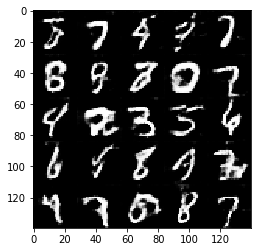

Epoch 2/2... Batch 410... Discriminator Loss: 1.4699... Generator Loss: 0.5666
Epoch 2/2... Batch 420... Discriminator Loss: 0.9711... Generator Loss: 1.0129
Epoch 2/2... Batch 430... Discriminator Loss: 1.2319... Generator Loss: 0.6811
Epoch 2/2... Batch 440... Discriminator Loss: 1.1487... Generator Loss: 1.0325
Epoch 2/2... Batch 450... Discriminator Loss: 0.9843... Generator Loss: 1.7147
Epoch 2/2... Batch 460... Discriminator Loss: 0.8301... Generator Loss: 1.9998
Epoch 2/2... Batch 470... Discriminator Loss: 0.9769... Generator Loss: 1.1828
Epoch 2/2... Batch 480... Discriminator Loss: 0.7342... Generator Loss: 2.5183
Epoch 2/2... Batch 490... Discriminator Loss: 0.9438... Generator Loss: 1.4879
Epoch 2/2... Batch 500... Discriminator Loss: 1.4017... Generator Loss: 0.6445


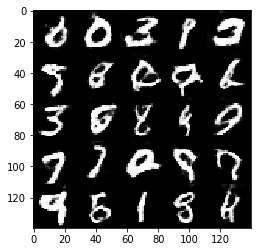

Epoch 2/2... Batch 510... Discriminator Loss: 0.7592... Generator Loss: 1.5821
Epoch 2/2... Batch 520... Discriminator Loss: 0.8725... Generator Loss: 2.0901
Epoch 2/2... Batch 530... Discriminator Loss: 1.0287... Generator Loss: 0.9413
Epoch 2/2... Batch 540... Discriminator Loss: 0.8607... Generator Loss: 1.6438
Epoch 2/2... Batch 550... Discriminator Loss: 1.0130... Generator Loss: 1.6113
Epoch 2/2... Batch 560... Discriminator Loss: 1.1848... Generator Loss: 1.6181
Epoch 2/2... Batch 570... Discriminator Loss: 1.1203... Generator Loss: 0.8080
Epoch 2/2... Batch 580... Discriminator Loss: 1.0765... Generator Loss: 0.8021
Epoch 2/2... Batch 590... Discriminator Loss: 1.6132... Generator Loss: 0.4766
Epoch 2/2... Batch 600... Discriminator Loss: 0.9676... Generator Loss: 1.1461


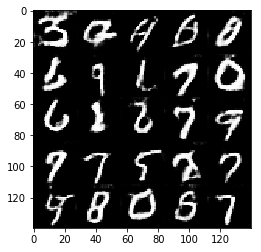

Epoch 2/2... Batch 610... Discriminator Loss: 1.0901... Generator Loss: 1.0455
Epoch 2/2... Batch 620... Discriminator Loss: 0.8837... Generator Loss: 1.4411
Epoch 2/2... Batch 630... Discriminator Loss: 0.8279... Generator Loss: 1.6008
Epoch 2/2... Batch 640... Discriminator Loss: 0.9251... Generator Loss: 1.6124
Epoch 2/2... Batch 650... Discriminator Loss: 1.5531... Generator Loss: 0.4526
Epoch 2/2... Batch 660... Discriminator Loss: 0.7854... Generator Loss: 1.6878
Epoch 2/2... Batch 670... Discriminator Loss: 0.6747... Generator Loss: 2.3916
Epoch 2/2... Batch 680... Discriminator Loss: 2.5261... Generator Loss: 0.2035
Epoch 2/2... Batch 690... Discriminator Loss: 1.1360... Generator Loss: 0.7960
Epoch 2/2... Batch 700... Discriminator Loss: 0.7694... Generator Loss: 1.4427


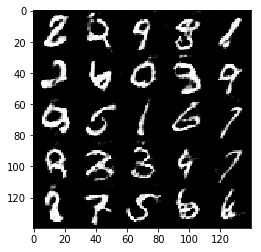

Epoch 2/2... Batch 710... Discriminator Loss: 0.5339... Generator Loss: 2.3362
Epoch 2/2... Batch 720... Discriminator Loss: 1.4372... Generator Loss: 3.7520
Epoch 2/2... Batch 730... Discriminator Loss: 2.9735... Generator Loss: 0.1342
Epoch 2/2... Batch 740... Discriminator Loss: 1.2104... Generator Loss: 0.7419
Epoch 2/2... Batch 750... Discriminator Loss: 0.8988... Generator Loss: 1.3016
Epoch 2/2... Batch 760... Discriminator Loss: 1.5352... Generator Loss: 0.4554
Epoch 2/2... Batch 770... Discriminator Loss: 0.8700... Generator Loss: 1.4471
Epoch 2/2... Batch 780... Discriminator Loss: 0.9028... Generator Loss: 1.3018
Epoch 2/2... Batch 790... Discriminator Loss: 1.7364... Generator Loss: 3.2920
Epoch 2/2... Batch 800... Discriminator Loss: 1.1729... Generator Loss: 0.7404


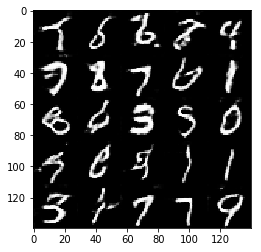

Epoch 2/2... Batch 810... Discriminator Loss: 0.8380... Generator Loss: 1.3066
Epoch 2/2... Batch 820... Discriminator Loss: 0.8193... Generator Loss: 1.2551
Epoch 2/2... Batch 830... Discriminator Loss: 0.8651... Generator Loss: 1.3390
Epoch 2/2... Batch 840... Discriminator Loss: 0.8822... Generator Loss: 1.2341
Epoch 2/2... Batch 850... Discriminator Loss: 2.7799... Generator Loss: 0.1793
Epoch 2/2... Batch 860... Discriminator Loss: 1.0900... Generator Loss: 0.9260
Epoch 2/2... Batch 870... Discriminator Loss: 1.5578... Generator Loss: 0.5240
Epoch 2/2... Batch 880... Discriminator Loss: 0.7013... Generator Loss: 1.6704
Epoch 2/2... Batch 890... Discriminator Loss: 1.7975... Generator Loss: 0.4754
Epoch 2/2... Batch 900... Discriminator Loss: 1.2764... Generator Loss: 2.3944


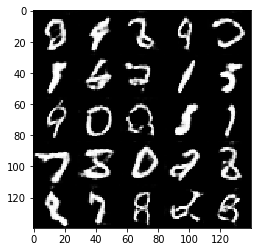

Epoch 2/2... Batch 910... Discriminator Loss: 1.1024... Generator Loss: 0.9559
Epoch 2/2... Batch 920... Discriminator Loss: 0.8271... Generator Loss: 1.5325
Epoch 2/2... Batch 930... Discriminator Loss: 1.1392... Generator Loss: 1.4847


In [36]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Batch 10... Discriminator Loss: 1.9299... Generator Loss: 4.7739
Epoch 1/2... Batch 20... Discriminator Loss: 1.0949... Generator Loss: 1.3119
Epoch 1/2... Batch 30... Discriminator Loss: 1.9324... Generator Loss: 3.4968
Epoch 1/2... Batch 40... Discriminator Loss: 0.8840... Generator Loss: 1.4439
Epoch 1/2... Batch 50... Discriminator Loss: 1.3325... Generator Loss: 2.2229
Epoch 1/2... Batch 60... Discriminator Loss: 1.4606... Generator Loss: 0.5497
Epoch 1/2... Batch 70... Discriminator Loss: 1.4605... Generator Loss: 0.5733
Epoch 1/2... Batch 80... Discriminator Loss: 1.2770... Generator Loss: 1.1434
Epoch 1/2... Batch 90... Discriminator Loss: 1.2743... Generator Loss: 0.7174
Epoch 1/2... Batch 100... Discriminator Loss: 1.8135... Generator Loss: 1.6225


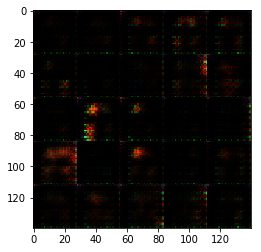

Epoch 1/2... Batch 110... Discriminator Loss: 0.9478... Generator Loss: 2.1424
Epoch 1/2... Batch 120... Discriminator Loss: 1.2558... Generator Loss: 1.7189
Epoch 1/2... Batch 130... Discriminator Loss: 1.3917... Generator Loss: 0.6528
Epoch 1/2... Batch 140... Discriminator Loss: 1.1276... Generator Loss: 1.1141
Epoch 1/2... Batch 150... Discriminator Loss: 1.0724... Generator Loss: 1.3034
Epoch 1/2... Batch 160... Discriminator Loss: 1.4721... Generator Loss: 1.0787
Epoch 1/2... Batch 170... Discriminator Loss: 1.0160... Generator Loss: 1.2385
Epoch 1/2... Batch 180... Discriminator Loss: 2.2505... Generator Loss: 0.3669
Epoch 1/2... Batch 190... Discriminator Loss: 1.2830... Generator Loss: 0.7888
Epoch 1/2... Batch 200... Discriminator Loss: 1.2500... Generator Loss: 0.9026


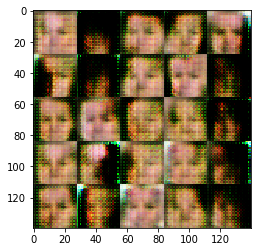

Epoch 1/2... Batch 210... Discriminator Loss: 1.1458... Generator Loss: 1.6117
Epoch 1/2... Batch 220... Discriminator Loss: 1.2327... Generator Loss: 0.8209
Epoch 1/2... Batch 230... Discriminator Loss: 1.1250... Generator Loss: 1.4973
Epoch 1/2... Batch 240... Discriminator Loss: 1.2429... Generator Loss: 1.3231
Epoch 1/2... Batch 250... Discriminator Loss: 1.4786... Generator Loss: 0.8163
Epoch 1/2... Batch 260... Discriminator Loss: 1.2142... Generator Loss: 0.9113
Epoch 1/2... Batch 270... Discriminator Loss: 1.5510... Generator Loss: 1.6517
Epoch 1/2... Batch 280... Discriminator Loss: 1.2997... Generator Loss: 0.8170
Epoch 1/2... Batch 290... Discriminator Loss: 1.4629... Generator Loss: 0.5923
Epoch 1/2... Batch 300... Discriminator Loss: 1.1646... Generator Loss: 1.0220


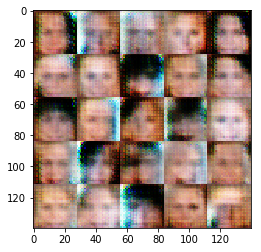

Epoch 1/2... Batch 310... Discriminator Loss: 1.2785... Generator Loss: 0.8773
Epoch 1/2... Batch 320... Discriminator Loss: 1.4217... Generator Loss: 0.7718
Epoch 1/2... Batch 330... Discriminator Loss: 1.4306... Generator Loss: 0.5693
Epoch 1/2... Batch 340... Discriminator Loss: 1.0204... Generator Loss: 1.0382
Epoch 1/2... Batch 350... Discriminator Loss: 1.4235... Generator Loss: 0.9038
Epoch 1/2... Batch 360... Discriminator Loss: 1.2422... Generator Loss: 0.8048
Epoch 1/2... Batch 370... Discriminator Loss: 1.2117... Generator Loss: 1.0367
Epoch 1/2... Batch 380... Discriminator Loss: 1.3919... Generator Loss: 1.0356
Epoch 1/2... Batch 390... Discriminator Loss: 1.3652... Generator Loss: 1.2699
Epoch 1/2... Batch 400... Discriminator Loss: 1.0626... Generator Loss: 1.0471


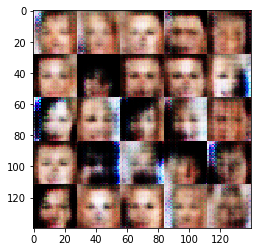

Epoch 1/2... Batch 410... Discriminator Loss: 1.1928... Generator Loss: 1.3391
Epoch 1/2... Batch 420... Discriminator Loss: 1.1634... Generator Loss: 0.8442
Epoch 1/2... Batch 430... Discriminator Loss: 1.4015... Generator Loss: 0.7112
Epoch 1/2... Batch 440... Discriminator Loss: 1.5911... Generator Loss: 0.3982
Epoch 1/2... Batch 450... Discriminator Loss: 1.2345... Generator Loss: 0.8266
Epoch 1/2... Batch 460... Discriminator Loss: 1.3369... Generator Loss: 0.7143
Epoch 1/2... Batch 470... Discriminator Loss: 1.2623... Generator Loss: 0.7549
Epoch 1/2... Batch 480... Discriminator Loss: 1.4478... Generator Loss: 0.4951
Epoch 1/2... Batch 490... Discriminator Loss: 1.3791... Generator Loss: 0.6230
Epoch 1/2... Batch 500... Discriminator Loss: 1.2024... Generator Loss: 0.8314


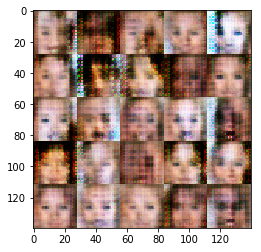

Epoch 1/2... Batch 510... Discriminator Loss: 1.1180... Generator Loss: 1.0127
Epoch 1/2... Batch 520... Discriminator Loss: 1.4118... Generator Loss: 0.7098
Epoch 1/2... Batch 530... Discriminator Loss: 2.3964... Generator Loss: 0.1831
Epoch 1/2... Batch 540... Discriminator Loss: 1.2582... Generator Loss: 0.9709
Epoch 1/2... Batch 550... Discriminator Loss: 1.4032... Generator Loss: 0.8705
Epoch 1/2... Batch 560... Discriminator Loss: 1.2339... Generator Loss: 1.0865
Epoch 1/2... Batch 570... Discriminator Loss: 1.5902... Generator Loss: 0.4304
Epoch 1/2... Batch 580... Discriminator Loss: 1.1494... Generator Loss: 0.6691
Epoch 1/2... Batch 590... Discriminator Loss: 1.2470... Generator Loss: 1.0139
Epoch 1/2... Batch 600... Discriminator Loss: 1.7136... Generator Loss: 2.0411


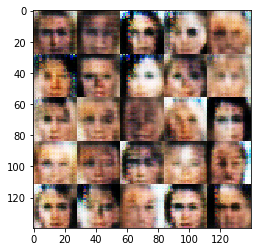

Epoch 1/2... Batch 610... Discriminator Loss: 1.2871... Generator Loss: 1.1586
Epoch 1/2... Batch 620... Discriminator Loss: 1.3672... Generator Loss: 0.5823
Epoch 1/2... Batch 630... Discriminator Loss: 1.3294... Generator Loss: 1.0018
Epoch 1/2... Batch 640... Discriminator Loss: 1.1685... Generator Loss: 1.1303
Epoch 1/2... Batch 650... Discriminator Loss: 1.2620... Generator Loss: 0.5962
Epoch 1/2... Batch 660... Discriminator Loss: 1.1104... Generator Loss: 1.0884
Epoch 1/2... Batch 670... Discriminator Loss: 1.3496... Generator Loss: 1.5167
Epoch 1/2... Batch 680... Discriminator Loss: 1.2171... Generator Loss: 0.8865
Epoch 1/2... Batch 690... Discriminator Loss: 1.1821... Generator Loss: 1.2632
Epoch 1/2... Batch 700... Discriminator Loss: 1.7157... Generator Loss: 0.3342


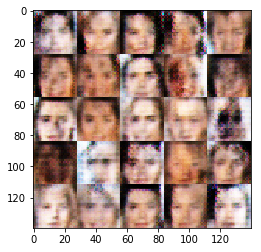

Epoch 1/2... Batch 710... Discriminator Loss: 1.2825... Generator Loss: 0.8630
Epoch 1/2... Batch 720... Discriminator Loss: 1.2577... Generator Loss: 1.3243
Epoch 1/2... Batch 730... Discriminator Loss: 1.4417... Generator Loss: 0.6982
Epoch 1/2... Batch 740... Discriminator Loss: 1.7242... Generator Loss: 1.9571
Epoch 1/2... Batch 750... Discriminator Loss: 1.2302... Generator Loss: 1.0610
Epoch 1/2... Batch 760... Discriminator Loss: 1.2118... Generator Loss: 1.0953
Epoch 1/2... Batch 770... Discriminator Loss: 1.4058... Generator Loss: 0.8249
Epoch 1/2... Batch 780... Discriminator Loss: 1.3124... Generator Loss: 0.8748
Epoch 1/2... Batch 790... Discriminator Loss: 1.3405... Generator Loss: 0.6803
Epoch 1/2... Batch 800... Discriminator Loss: 1.5848... Generator Loss: 1.4238


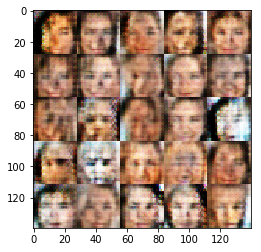

Epoch 1/2... Batch 810... Discriminator Loss: 1.2114... Generator Loss: 0.9719
Epoch 1/2... Batch 820... Discriminator Loss: 1.1578... Generator Loss: 1.3951
Epoch 1/2... Batch 830... Discriminator Loss: 1.7572... Generator Loss: 0.6653
Epoch 1/2... Batch 840... Discriminator Loss: 1.7086... Generator Loss: 1.9821
Epoch 1/2... Batch 850... Discriminator Loss: 1.3347... Generator Loss: 0.6234
Epoch 1/2... Batch 860... Discriminator Loss: 1.2450... Generator Loss: 0.8529
Epoch 1/2... Batch 870... Discriminator Loss: 1.3260... Generator Loss: 1.1272
Epoch 1/2... Batch 880... Discriminator Loss: 1.8847... Generator Loss: 2.2807
Epoch 1/2... Batch 890... Discriminator Loss: 1.9991... Generator Loss: 2.2692
Epoch 1/2... Batch 900... Discriminator Loss: 1.2219... Generator Loss: 0.9183


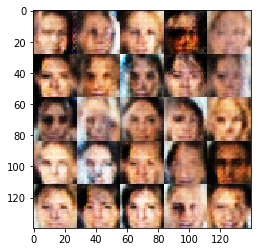

Epoch 1/2... Batch 910... Discriminator Loss: 1.0727... Generator Loss: 1.1162
Epoch 1/2... Batch 920... Discriminator Loss: 1.4384... Generator Loss: 1.1153
Epoch 1/2... Batch 930... Discriminator Loss: 1.3333... Generator Loss: 1.3464
Epoch 1/2... Batch 940... Discriminator Loss: 1.2917... Generator Loss: 0.8231
Epoch 1/2... Batch 950... Discriminator Loss: 1.7320... Generator Loss: 0.6990
Epoch 1/2... Batch 960... Discriminator Loss: 1.4330... Generator Loss: 1.0073
Epoch 1/2... Batch 970... Discriminator Loss: 1.1168... Generator Loss: 0.8320
Epoch 1/2... Batch 980... Discriminator Loss: 1.2681... Generator Loss: 0.9148
Epoch 1/2... Batch 990... Discriminator Loss: 1.2003... Generator Loss: 1.1937
Epoch 1/2... Batch 1000... Discriminator Loss: 1.5199... Generator Loss: 0.6594


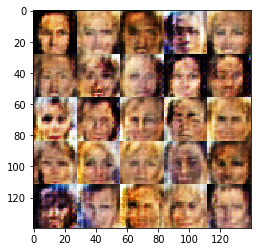

Epoch 1/2... Batch 1010... Discriminator Loss: 1.3108... Generator Loss: 1.0304
Epoch 1/2... Batch 1020... Discriminator Loss: 1.3288... Generator Loss: 0.7559
Epoch 1/2... Batch 1030... Discriminator Loss: 1.3408... Generator Loss: 0.7054
Epoch 1/2... Batch 1040... Discriminator Loss: 1.4742... Generator Loss: 1.3055
Epoch 1/2... Batch 1050... Discriminator Loss: 1.3812... Generator Loss: 0.6495
Epoch 1/2... Batch 1060... Discriminator Loss: 1.2950... Generator Loss: 1.0360
Epoch 1/2... Batch 1070... Discriminator Loss: 1.4154... Generator Loss: 0.8795
Epoch 1/2... Batch 1080... Discriminator Loss: 1.3178... Generator Loss: 0.8933
Epoch 1/2... Batch 1090... Discriminator Loss: 1.4255... Generator Loss: 0.6983
Epoch 1/2... Batch 1100... Discriminator Loss: 1.4478... Generator Loss: 0.6389


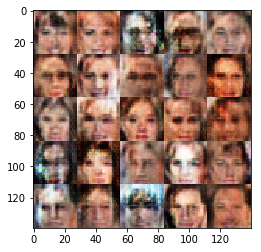

Epoch 1/2... Batch 1110... Discriminator Loss: 1.3220... Generator Loss: 0.7491
Epoch 1/2... Batch 1120... Discriminator Loss: 1.3650... Generator Loss: 0.8419
Epoch 1/2... Batch 1130... Discriminator Loss: 1.2922... Generator Loss: 0.8765
Epoch 1/2... Batch 1140... Discriminator Loss: 1.3945... Generator Loss: 0.7076
Epoch 1/2... Batch 1150... Discriminator Loss: 1.5129... Generator Loss: 0.6758
Epoch 1/2... Batch 1160... Discriminator Loss: 1.5366... Generator Loss: 1.1404
Epoch 1/2... Batch 1170... Discriminator Loss: 1.3823... Generator Loss: 0.7616
Epoch 1/2... Batch 1180... Discriminator Loss: 1.2471... Generator Loss: 1.0119
Epoch 1/2... Batch 1190... Discriminator Loss: 1.9189... Generator Loss: 2.7616
Epoch 1/2... Batch 1200... Discriminator Loss: 1.4055... Generator Loss: 0.7489


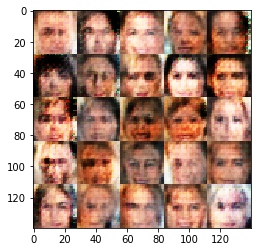

Epoch 1/2... Batch 1210... Discriminator Loss: 1.3059... Generator Loss: 0.8503
Epoch 1/2... Batch 1220... Discriminator Loss: 1.2458... Generator Loss: 0.8084
Epoch 1/2... Batch 1230... Discriminator Loss: 1.3321... Generator Loss: 0.8470
Epoch 1/2... Batch 1240... Discriminator Loss: 1.3223... Generator Loss: 1.3804
Epoch 1/2... Batch 1250... Discriminator Loss: 1.3965... Generator Loss: 0.5832
Epoch 1/2... Batch 1260... Discriminator Loss: 1.2909... Generator Loss: 0.7515
Epoch 1/2... Batch 1270... Discriminator Loss: 1.3513... Generator Loss: 0.6606
Epoch 1/2... Batch 1280... Discriminator Loss: 1.2281... Generator Loss: 0.8797
Epoch 1/2... Batch 1290... Discriminator Loss: 1.3229... Generator Loss: 0.7917
Epoch 1/2... Batch 1300... Discriminator Loss: 1.2108... Generator Loss: 0.7356


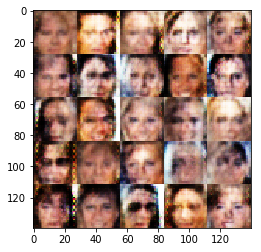

Epoch 1/2... Batch 1310... Discriminator Loss: 1.2266... Generator Loss: 0.9165
Epoch 1/2... Batch 1320... Discriminator Loss: 1.3347... Generator Loss: 0.7539
Epoch 1/2... Batch 1330... Discriminator Loss: 1.2555... Generator Loss: 0.9061
Epoch 1/2... Batch 1340... Discriminator Loss: 1.3639... Generator Loss: 0.7676
Epoch 1/2... Batch 1350... Discriminator Loss: 1.3074... Generator Loss: 1.0857
Epoch 1/2... Batch 1360... Discriminator Loss: 1.1943... Generator Loss: 0.7235
Epoch 1/2... Batch 1370... Discriminator Loss: 1.2967... Generator Loss: 1.1841
Epoch 1/2... Batch 1380... Discriminator Loss: 1.3598... Generator Loss: 0.7389
Epoch 1/2... Batch 1390... Discriminator Loss: 1.3039... Generator Loss: 0.7589
Epoch 1/2... Batch 1400... Discriminator Loss: 1.2194... Generator Loss: 0.9844


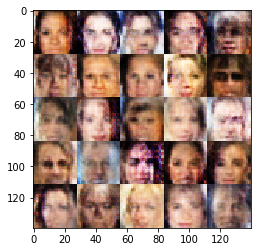

Epoch 1/2... Batch 1410... Discriminator Loss: 1.4898... Generator Loss: 0.5665
Epoch 1/2... Batch 1420... Discriminator Loss: 1.2118... Generator Loss: 0.8543
Epoch 1/2... Batch 1430... Discriminator Loss: 1.2241... Generator Loss: 1.2243
Epoch 1/2... Batch 1440... Discriminator Loss: 1.4563... Generator Loss: 1.0248
Epoch 1/2... Batch 1450... Discriminator Loss: 1.2284... Generator Loss: 0.9237
Epoch 1/2... Batch 1460... Discriminator Loss: 1.3370... Generator Loss: 1.5424
Epoch 1/2... Batch 1470... Discriminator Loss: 1.2962... Generator Loss: 1.0124
Epoch 1/2... Batch 1480... Discriminator Loss: 1.9359... Generator Loss: 2.3807
Epoch 1/2... Batch 1490... Discriminator Loss: 1.2589... Generator Loss: 0.8795
Epoch 1/2... Batch 1500... Discriminator Loss: 1.3409... Generator Loss: 0.8426


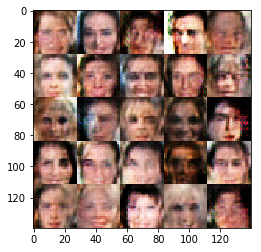

Epoch 1/2... Batch 1510... Discriminator Loss: 1.2245... Generator Loss: 1.4888
Epoch 1/2... Batch 1520... Discriminator Loss: 1.2789... Generator Loss: 1.2347
Epoch 1/2... Batch 1530... Discriminator Loss: 0.9924... Generator Loss: 1.0515
Epoch 1/2... Batch 1540... Discriminator Loss: 1.2535... Generator Loss: 0.8326
Epoch 1/2... Batch 1550... Discriminator Loss: 1.4361... Generator Loss: 0.7429
Epoch 1/2... Batch 1560... Discriminator Loss: 1.2264... Generator Loss: 0.8967
Epoch 1/2... Batch 1570... Discriminator Loss: 1.0929... Generator Loss: 0.8554
Epoch 1/2... Batch 1580... Discriminator Loss: 1.2580... Generator Loss: 1.1440
Epoch 2/2... Batch 10... Discriminator Loss: 1.1249... Generator Loss: 1.5878
Epoch 2/2... Batch 20... Discriminator Loss: 1.3936... Generator Loss: 0.6531
Epoch 2/2... Batch 30... Discriminator Loss: 1.3516... Generator Loss: 1.2592
Epoch 2/2... Batch 40... Discriminator Loss: 1.3063... Generator Loss: 1.2429
Epoch 2/2... Batch 50... Discriminator Loss: 1.3

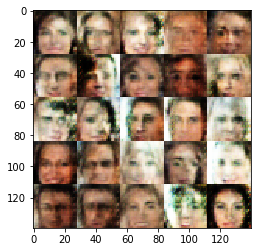

Epoch 2/2... Batch 110... Discriminator Loss: 1.3685... Generator Loss: 1.2592
Epoch 2/2... Batch 120... Discriminator Loss: 1.2226... Generator Loss: 1.5105
Epoch 2/2... Batch 130... Discriminator Loss: 1.5479... Generator Loss: 0.4661
Epoch 2/2... Batch 140... Discriminator Loss: 1.6363... Generator Loss: 1.4229
Epoch 2/2... Batch 150... Discriminator Loss: 1.3404... Generator Loss: 0.7545
Epoch 2/2... Batch 160... Discriminator Loss: 1.2804... Generator Loss: 0.9764
Epoch 2/2... Batch 170... Discriminator Loss: 1.2178... Generator Loss: 0.7622
Epoch 2/2... Batch 180... Discriminator Loss: 1.2146... Generator Loss: 0.7359
Epoch 2/2... Batch 190... Discriminator Loss: 1.1941... Generator Loss: 1.2046
Epoch 2/2... Batch 200... Discriminator Loss: 1.3431... Generator Loss: 0.5372


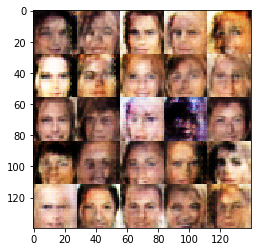

Epoch 2/2... Batch 210... Discriminator Loss: 1.2655... Generator Loss: 0.9451
Epoch 2/2... Batch 220... Discriminator Loss: 1.2440... Generator Loss: 0.7524
Epoch 2/2... Batch 230... Discriminator Loss: 1.2592... Generator Loss: 0.9897
Epoch 2/2... Batch 240... Discriminator Loss: 1.1462... Generator Loss: 1.2321
Epoch 2/2... Batch 250... Discriminator Loss: 1.4423... Generator Loss: 0.5601
Epoch 2/2... Batch 260... Discriminator Loss: 1.2769... Generator Loss: 0.9398
Epoch 2/2... Batch 270... Discriminator Loss: 1.3371... Generator Loss: 1.4548
Epoch 2/2... Batch 280... Discriminator Loss: 1.2404... Generator Loss: 1.5170
Epoch 2/2... Batch 290... Discriminator Loss: 1.1075... Generator Loss: 0.8351
Epoch 2/2... Batch 300... Discriminator Loss: 1.3122... Generator Loss: 0.7274


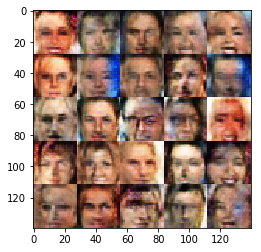

Epoch 2/2... Batch 310... Discriminator Loss: 1.3669... Generator Loss: 0.6248
Epoch 2/2... Batch 320... Discriminator Loss: 1.1641... Generator Loss: 0.9055
Epoch 2/2... Batch 330... Discriminator Loss: 1.4534... Generator Loss: 0.6763
Epoch 2/2... Batch 340... Discriminator Loss: 1.2341... Generator Loss: 0.9302
Epoch 2/2... Batch 350... Discriminator Loss: 1.3627... Generator Loss: 0.6223
Epoch 2/2... Batch 360... Discriminator Loss: 1.6726... Generator Loss: 1.2931
Epoch 2/2... Batch 370... Discriminator Loss: 1.2141... Generator Loss: 0.9122
Epoch 2/2... Batch 380... Discriminator Loss: 1.4908... Generator Loss: 0.7396
Epoch 2/2... Batch 390... Discriminator Loss: 1.4917... Generator Loss: 0.5411
Epoch 2/2... Batch 400... Discriminator Loss: 1.1907... Generator Loss: 0.8709


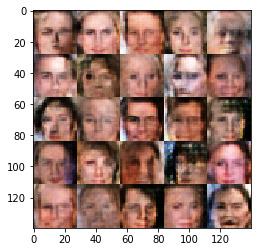

Epoch 2/2... Batch 410... Discriminator Loss: 1.1667... Generator Loss: 1.0945
Epoch 2/2... Batch 420... Discriminator Loss: 1.3566... Generator Loss: 1.2734
Epoch 2/2... Batch 430... Discriminator Loss: 1.2610... Generator Loss: 0.9314
Epoch 2/2... Batch 440... Discriminator Loss: 1.1848... Generator Loss: 0.7563
Epoch 2/2... Batch 450... Discriminator Loss: 1.3268... Generator Loss: 0.7130
Epoch 2/2... Batch 460... Discriminator Loss: 1.3468... Generator Loss: 0.8580
Epoch 2/2... Batch 470... Discriminator Loss: 1.2988... Generator Loss: 0.8072
Epoch 2/2... Batch 480... Discriminator Loss: 1.4662... Generator Loss: 0.8714
Epoch 2/2... Batch 490... Discriminator Loss: 1.2834... Generator Loss: 0.9405
Epoch 2/2... Batch 500... Discriminator Loss: 1.6388... Generator Loss: 1.3166


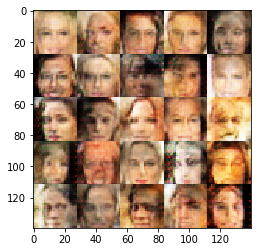

Epoch 2/2... Batch 510... Discriminator Loss: 1.2328... Generator Loss: 1.2137
Epoch 2/2... Batch 520... Discriminator Loss: 1.2158... Generator Loss: 1.2426
Epoch 2/2... Batch 530... Discriminator Loss: 1.2190... Generator Loss: 0.9692
Epoch 2/2... Batch 540... Discriminator Loss: 1.3245... Generator Loss: 1.0123
Epoch 2/2... Batch 550... Discriminator Loss: 1.2733... Generator Loss: 1.5666
Epoch 2/2... Batch 560... Discriminator Loss: 1.3791... Generator Loss: 0.8838
Epoch 2/2... Batch 570... Discriminator Loss: 1.5556... Generator Loss: 0.4883
Epoch 2/2... Batch 580... Discriminator Loss: 1.3202... Generator Loss: 0.5919
Epoch 2/2... Batch 590... Discriminator Loss: 1.4426... Generator Loss: 0.7087
Epoch 2/2... Batch 600... Discriminator Loss: 1.3685... Generator Loss: 0.7683


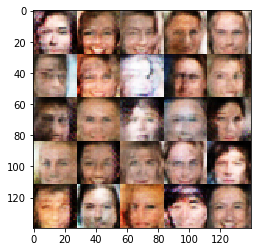

Epoch 2/2... Batch 610... Discriminator Loss: 1.3136... Generator Loss: 0.9956
Epoch 2/2... Batch 620... Discriminator Loss: 1.3558... Generator Loss: 0.6122
Epoch 2/2... Batch 630... Discriminator Loss: 1.4091... Generator Loss: 0.7452
Epoch 2/2... Batch 640... Discriminator Loss: 1.2727... Generator Loss: 0.9103
Epoch 2/2... Batch 650... Discriminator Loss: 1.3675... Generator Loss: 1.1118
Epoch 2/2... Batch 660... Discriminator Loss: 1.2870... Generator Loss: 0.8083
Epoch 2/2... Batch 670... Discriminator Loss: 1.1325... Generator Loss: 0.8983
Epoch 2/2... Batch 680... Discriminator Loss: 1.2391... Generator Loss: 0.9601
Epoch 2/2... Batch 690... Discriminator Loss: 1.3311... Generator Loss: 1.3895
Epoch 2/2... Batch 700... Discriminator Loss: 1.2473... Generator Loss: 0.8888


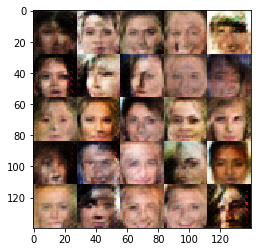

Epoch 2/2... Batch 710... Discriminator Loss: 1.2194... Generator Loss: 1.0222
Epoch 2/2... Batch 720... Discriminator Loss: 1.4084... Generator Loss: 0.9701
Epoch 2/2... Batch 730... Discriminator Loss: 1.3733... Generator Loss: 0.8745
Epoch 2/2... Batch 740... Discriminator Loss: 1.1710... Generator Loss: 1.0897
Epoch 2/2... Batch 750... Discriminator Loss: 1.2133... Generator Loss: 0.7466
Epoch 2/2... Batch 760... Discriminator Loss: 1.2782... Generator Loss: 0.8380
Epoch 2/2... Batch 770... Discriminator Loss: 1.2955... Generator Loss: 0.8652
Epoch 2/2... Batch 780... Discriminator Loss: 1.1499... Generator Loss: 0.7693
Epoch 2/2... Batch 790... Discriminator Loss: 1.5150... Generator Loss: 1.6246
Epoch 2/2... Batch 800... Discriminator Loss: 1.2843... Generator Loss: 0.8314


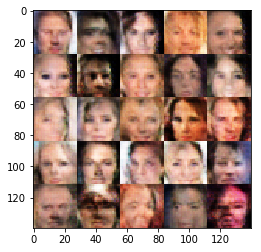

Epoch 2/2... Batch 810... Discriminator Loss: 1.3261... Generator Loss: 0.6078
Epoch 2/2... Batch 820... Discriminator Loss: 1.3565... Generator Loss: 0.7687
Epoch 2/2... Batch 830... Discriminator Loss: 1.2741... Generator Loss: 0.9317
Epoch 2/2... Batch 840... Discriminator Loss: 1.3738... Generator Loss: 0.5898
Epoch 2/2... Batch 850... Discriminator Loss: 1.1737... Generator Loss: 1.1028
Epoch 2/2... Batch 860... Discriminator Loss: 1.3978... Generator Loss: 0.7475
Epoch 2/2... Batch 870... Discriminator Loss: 1.1194... Generator Loss: 1.0094
Epoch 2/2... Batch 880... Discriminator Loss: 1.4851... Generator Loss: 0.4596
Epoch 2/2... Batch 890... Discriminator Loss: 1.3613... Generator Loss: 0.8782
Epoch 2/2... Batch 900... Discriminator Loss: 1.1511... Generator Loss: 0.9932


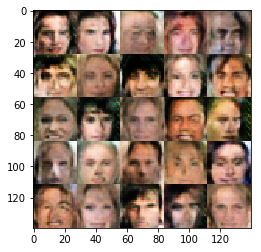

Epoch 2/2... Batch 910... Discriminator Loss: 1.3717... Generator Loss: 0.7013
Epoch 2/2... Batch 920... Discriminator Loss: 1.3787... Generator Loss: 0.8067
Epoch 2/2... Batch 930... Discriminator Loss: 1.2883... Generator Loss: 0.8486
Epoch 2/2... Batch 940... Discriminator Loss: 1.1655... Generator Loss: 1.1092
Epoch 2/2... Batch 950... Discriminator Loss: 1.2636... Generator Loss: 0.9722
Epoch 2/2... Batch 960... Discriminator Loss: 1.2587... Generator Loss: 0.9469
Epoch 2/2... Batch 970... Discriminator Loss: 1.2289... Generator Loss: 0.8443
Epoch 2/2... Batch 980... Discriminator Loss: 1.2065... Generator Loss: 1.0220
Epoch 2/2... Batch 990... Discriminator Loss: 1.4840... Generator Loss: 0.5157
Epoch 2/2... Batch 1000... Discriminator Loss: 1.3313... Generator Loss: 1.0293


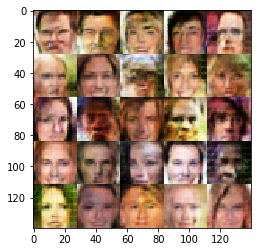

Epoch 2/2... Batch 1010... Discriminator Loss: 1.3410... Generator Loss: 1.1152
Epoch 2/2... Batch 1020... Discriminator Loss: 1.3001... Generator Loss: 1.0241
Epoch 2/2... Batch 1030... Discriminator Loss: 1.2463... Generator Loss: 0.8377
Epoch 2/2... Batch 1040... Discriminator Loss: 1.2423... Generator Loss: 0.9029
Epoch 2/2... Batch 1050... Discriminator Loss: 1.2282... Generator Loss: 0.9459
Epoch 2/2... Batch 1060... Discriminator Loss: 1.5467... Generator Loss: 0.4577
Epoch 2/2... Batch 1070... Discriminator Loss: 1.3188... Generator Loss: 0.5841
Epoch 2/2... Batch 1080... Discriminator Loss: 1.2646... Generator Loss: 1.0004
Epoch 2/2... Batch 1090... Discriminator Loss: 1.3791... Generator Loss: 0.7923
Epoch 2/2... Batch 1100... Discriminator Loss: 1.0708... Generator Loss: 1.2263


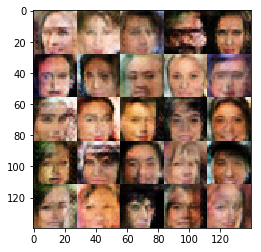

Epoch 2/2... Batch 1110... Discriminator Loss: 1.2242... Generator Loss: 0.9325
Epoch 2/2... Batch 1120... Discriminator Loss: 1.3418... Generator Loss: 0.9049
Epoch 2/2... Batch 1130... Discriminator Loss: 1.2226... Generator Loss: 1.0550
Epoch 2/2... Batch 1140... Discriminator Loss: 1.4844... Generator Loss: 0.7118
Epoch 2/2... Batch 1150... Discriminator Loss: 1.5702... Generator Loss: 1.4594
Epoch 2/2... Batch 1160... Discriminator Loss: 1.2107... Generator Loss: 0.8698
Epoch 2/2... Batch 1170... Discriminator Loss: 1.2780... Generator Loss: 0.8846
Epoch 2/2... Batch 1180... Discriminator Loss: 1.2009... Generator Loss: 0.8740
Epoch 2/2... Batch 1190... Discriminator Loss: 1.2764... Generator Loss: 1.2087
Epoch 2/2... Batch 1200... Discriminator Loss: 1.3008... Generator Loss: 0.6913


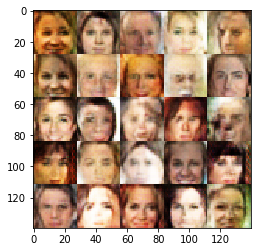

Epoch 2/2... Batch 1210... Discriminator Loss: 1.3033... Generator Loss: 0.9994
Epoch 2/2... Batch 1220... Discriminator Loss: 1.3862... Generator Loss: 0.6798
Epoch 2/2... Batch 1230... Discriminator Loss: 1.2757... Generator Loss: 0.7728
Epoch 2/2... Batch 1240... Discriminator Loss: 1.3193... Generator Loss: 1.3612
Epoch 2/2... Batch 1250... Discriminator Loss: 1.2488... Generator Loss: 1.0112
Epoch 2/2... Batch 1260... Discriminator Loss: 1.2541... Generator Loss: 0.9175
Epoch 2/2... Batch 1270... Discriminator Loss: 1.1594... Generator Loss: 1.0435
Epoch 2/2... Batch 1280... Discriminator Loss: 1.3099... Generator Loss: 0.7522
Epoch 2/2... Batch 1290... Discriminator Loss: 1.4132... Generator Loss: 0.6618
Epoch 2/2... Batch 1300... Discriminator Loss: 1.2687... Generator Loss: 0.6167


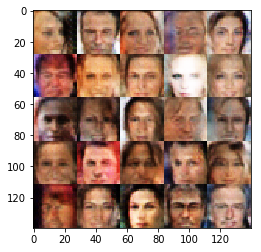

Epoch 2/2... Batch 1310... Discriminator Loss: 1.4180... Generator Loss: 0.6847
Epoch 2/2... Batch 1320... Discriminator Loss: 1.3272... Generator Loss: 0.9120
Epoch 2/2... Batch 1330... Discriminator Loss: 1.2570... Generator Loss: 1.1150
Epoch 2/2... Batch 1340... Discriminator Loss: 1.2665... Generator Loss: 1.1294
Epoch 2/2... Batch 1350... Discriminator Loss: 1.2563... Generator Loss: 1.2600
Epoch 2/2... Batch 1360... Discriminator Loss: 1.2502... Generator Loss: 0.9754
Epoch 2/2... Batch 1370... Discriminator Loss: 1.2672... Generator Loss: 0.9009
Epoch 2/2... Batch 1380... Discriminator Loss: 1.3123... Generator Loss: 0.8302
Epoch 2/2... Batch 1390... Discriminator Loss: 1.2632... Generator Loss: 0.7999
Epoch 2/2... Batch 1400... Discriminator Loss: 1.4445... Generator Loss: 1.1813


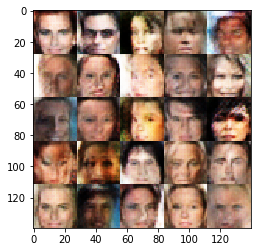

Epoch 2/2... Batch 1410... Discriminator Loss: 1.3987... Generator Loss: 0.7389
Epoch 2/2... Batch 1420... Discriminator Loss: 1.4229... Generator Loss: 0.7366
Epoch 2/2... Batch 1430... Discriminator Loss: 1.3136... Generator Loss: 1.1035
Epoch 2/2... Batch 1440... Discriminator Loss: 1.3815... Generator Loss: 1.0327
Epoch 2/2... Batch 1450... Discriminator Loss: 1.4098... Generator Loss: 0.8622
Epoch 2/2... Batch 1460... Discriminator Loss: 1.2176... Generator Loss: 0.8217
Epoch 2/2... Batch 1470... Discriminator Loss: 1.3343... Generator Loss: 0.8164
Epoch 2/2... Batch 1480... Discriminator Loss: 1.3856... Generator Loss: 1.2498
Epoch 2/2... Batch 1490... Discriminator Loss: 1.2840... Generator Loss: 0.9511
Epoch 2/2... Batch 1500... Discriminator Loss: 1.4317... Generator Loss: 1.0552


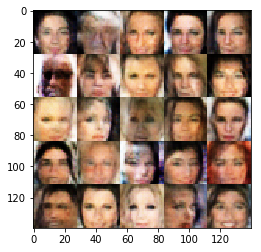

Epoch 2/2... Batch 1510... Discriminator Loss: 1.2950... Generator Loss: 1.1072
Epoch 2/2... Batch 1520... Discriminator Loss: 1.2165... Generator Loss: 1.4205
Epoch 2/2... Batch 1530... Discriminator Loss: 1.1834... Generator Loss: 1.0516
Epoch 2/2... Batch 1540... Discriminator Loss: 1.1425... Generator Loss: 1.0858
Epoch 2/2... Batch 1550... Discriminator Loss: 1.2763... Generator Loss: 0.8386
Epoch 2/2... Batch 1560... Discriminator Loss: 1.3780... Generator Loss: 0.8286
Epoch 2/2... Batch 1570... Discriminator Loss: 1.3653... Generator Loss: 0.6057
Epoch 2/2... Batch 1580... Discriminator Loss: 1.3995... Generator Loss: 1.3189


In [37]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.